In [1]:
%reset -f
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import re, sqlite3, pickle, time, datetime, random, sys
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

pd.options.display.float_format = '{:,.3f}'.format

2022-10-15 15:35:52.521059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-10-15 15:35:52.521090: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 0. Functions 

### 0.1. Encoding functions

In [2]:
############################################################
# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
############################################################
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat], [mean, std]])
        elif data_types[feat] == 'Categorical':
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat], df])
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif data_types[feat] == 'Categorical':
            df = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
############################################################

### 0.2. Split Data Function

In [3]:
def train_valid_sets(X_train_set, X_valid_set):
    #######################################
    ### BALANCED DATA
    #######################################
    random.seed(2)
    X_0 = X_train_set[X_train_set['Mortality'] == 0]
    X_1 = X_train_set[X_train_set['Mortality'] == 1]

    list_X_0 = random.sample(range(len(X_0)),len(X_1))
    X_0_2 = X_0.iloc[list_X_0]

    X_data_bal = pd.concat([X_1,X_0_2])
    
    #######################################
    ### SPLIT DATA
    #######################################
    
    train_set = X_data_bal
    valid_set = X_valid_set

    print('total admissions 16 18', len(X_train_set))
    print('total admissions 19 20', len(X_valid_set))
    print('X_train', len(train_set))
    print('Admissions neg (mortal - class = 0):', len(train_set[train_set['Mortality']==0]),
          'Admissions pos (recover- class = 1):', len(train_set[train_set['Mortality']==1]))
    print('X_valid', len(valid_set))
    print('Admissions neg (mortal - class = 0):', len(valid_set[valid_set['Mortality']==0]), 
          'Admissions pos (recover- class = 1):', len(valid_set[valid_set['Mortality']==1]))
    return train_set, valid_set

### 0.3. Encoding Data Function

In [4]:
def encoding_data(train_set, valid_set, feat_list, data_types):
    ############################################################
    train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
    valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)
    print("==========================================================================================================")
    print('----------------------------------TRAIN SET---------------------------------------------------------------')
    print("==========================================================================================================")
    display(train_set.head(4))
    display(train_set_norm.head(4))
    print("==========================================================================================================")
    print('----------------------------------VALIDATION SET----------------------------------------------------------')
    print("==========================================================================================================")
    display(valid_set.head(4))
    display(valid_set_norm.head(4))
    display(encoder)
    return train_set_norm, valid_set_norm, encoder

# 1. Load Data

In [5]:
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'

X_data_16_18 = pickle.load(open(path + 'df_first_curb_2016_18.pickle','rb'))
X_data_19_20 = pickle.load(open(path + 'df_first_curb_2019_20.pickle','rb'))


print("=================================FIRST RECORDED SAMPLE ADMISSION=================================")
print("-------------------------------------- 2016 - 2018 ----------------------------------------------")
display(X_data_16_18[0].head(3))
print("")
print("-------------------------------------- 2019 - 2020 ----------------------------------------------")
display(X_data_19_20[0].head(3))

print("Elapsed time:", time.time()-t)

=================================FIRST RECORDED SAMPLE ADMISSION=================================
-------------------------------------- 2016 - 2018 ----------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,38552641,34.000,11,118.000,39.200,100.000,55.000,96.000,1.000,0,-1,3,54,2,1,1.000,0
144,37660212,24.000,7,75.000,37.000,100.000,54.000,95.000,1.000,0,-1,0,47,0,0,0.000,0
288,67150633,24.000,4,75.000,37.800,117.000,72.000,92.000,1.000,1,-1,0,84,8,0,0.000,0



-------------------------------------- 2019 - 2020 ----------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,25298427,18.000,3,88.000,37.000,76.000,54.000,100.000,0.000,0,-1,0,64,6,0,1.000,0
144,31669457,22.000,9,135.000,38.500,148.000,97.000,95.000,1.000,0,-1,0,36,0,0,0.000,0
288,52534553,16.000,2,66.000,37.100,136.000,84.000,100.000,1.000,0,1,1,84,3,0,0.000,0


Elapsed time: 0.034487009048461914


In [6]:
feat_list = X_data_16_18[0].columns.tolist()
feat_list = feat_list[1:-1]
print(feat_list)
print("Number of features:",len(feat_list))

['rr', 'ews', 'heart_rate', 'temperature', 'sbp', 'dbp', 'Oxygen_Saturation', 'Assisted_O2', 'Confusion', 'sex', 'ethnicity', 'age_at_admin', 'Comorb_score', 'Spcfc_Comorb', 'had_Prev_admin']
Number of features: 15


In [7]:
# Loading the CSV with types
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
# Dictionary of features and types
data_types = data_types.set_index('Variable').to_dict()['Type']

# Modelling parametersRF Classfier

In [8]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier


# define model
model = RandomForestClassifier(max_features = None, n_jobs=-1, bootstrap =  True, random_state = 0)

# define grid
weights = [{1:1}, {1:2}, {1:3}, {1:4},{1:5},{1:8},{1:10}, {1:25},{1:50},{1:75},{1:99},{1:100},{1:500}]
param_grid = dict(class_weight =weights)
scoring = {"AUC": "roc_auc", "Recall": "recall"}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=scoring, refit = "Recall")

# 2. Modelling RF classifier

In [9]:


def train_grid_XGB_model(train_set, valid_set, X_train_set, X_valid_set, grid, feat_list):
    df_results_train = pd.DataFrame()
    df_results       = pd.DataFrame()
    dict_fpr_tpr     = {}
    X_train = np.array(train_set[feat_list]); Y_train = np.array(X_train_set['Mortality'])
    X_valid = np.array(valid_set[feat_list]); Y_valid = np.array(X_valid_set['Mortality'])
    #################################################################
    #################################################################
    # TRAINING THE MODEL
    #################################################################
    t = time.time()
    # execute the grid search
    grid_result = grid.fit(X_train, Y_train)
    # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # report all configurations
    auc_means = grid_result.cv_results_['mean_test_AUC']
    rcl_means = grid_result.cv_results_['mean_test_Recall']
    params    = grid_result.cv_results_['params']
    print("AUC    (call)")
    for mean, rcl, param in zip(auc_means, rcl_means, params):
        print("%f (%f) with: %r" % (mean, rcl, param))    
    df_results_train['NoF_auc'] = auc_means
    df_results_train['NoF_rcl'] = rcl_means
    print("")
    print("time elapased training: ", time.time()-t)
    #################################################################
    #################################################################
    # results - Model Validation
    #################################################################

    y_scores  = grid.predict(X_valid)
    y_predict = FineTuning.adjusted_classes(y_scores, 0.5)
    y_proba   = grid.predict_proba(X_valid)[:,1]
    df_results, fpr_tpr = LearningCurves.results_precision_recall_cm(Y_valid, y_predict, y_proba, fig_size = None)
    plt.show()
    dict_fpr_tpr['NoF'] = fpr_tpr
    df_results = df_results.set_index(pd.Series('NoF'))
    display(df_results)
    return [df_results_train, df_results, dict_fpr_tpr]

# CURB65 Group 1

In [10]:
X_train_set = X_data_16_18[0]
X_valid_set = X_data_19_20[0]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1161
total admissions 19 20 409
X_train 102
Admissions neg (mortal - class = 0): 51 Admissions pos (recover- class = 1): 51
X_valid 409
Admissions neg (mortal - class = 0): 378 Admissions pos (recover- class = 1): 31

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
576,31151576,24.000,4,86.000,38.000,115.000,77.000,97.000,1.000,0,-1,0,92,2,1,0.000,1
864,62984364,22.000,5,85.000,37.000,106.000,62.000,96.000,1.000,0,1,0,44,0,1,0.000,1
6624,12588258,18.000,2,95.000,36.400,111.000,85.000,95.000,1.000,1,-1,0,82,0,0,1.000,1
8784,3833706,26.000,6,110.000,37.700,140.000,79.000,100.000,1.000,0,-1,0,67,3,1,0.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
576,0.291,0.500,-0.829,0.931,-0.683,-0.049,0.623,1.000,0,-1,0.517,1.645,-0.234,1,0.000
864,-0.145,0.600,-0.880,-0.284,-1.069,-1.198,0.342,1.000,0,1,0.517,-1.100,-0.716,1,0.000
6624,-1.017,0.545,-0.370,-1.013,-0.855,0.563,0.061,1.000,1,-1,0.517,1.073,-0.716,0,1.000
8784,0.727,0.429,0.394,0.566,0.387,0.104,1.467,1.000,0,-1,0.517,0.215,0.007,1,0.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,25298427,18.000,3,88.000,37.000,76.000,54.000,100.000,0.000,0,-1,0,64,6,0,1.000,0
144,31669457,22.000,9,135.000,38.500,148.000,97.000,95.000,1.000,0,-1,0,36,0,0,0.000,0
288,52534553,16.000,2,66.000,37.100,136.000,84.000,100.000,1.000,0,1,1,84,3,0,0.000,0
432,21124330,20.000,4,91.000,37.100,123.000,76.000,94.000,1.000,0,1,0,67,0,0,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-1.017,0.214,-0.727,-0.284,-2.354,-1.811,1.467,0.000,0,-1,0.517,0.044,0.730,0,1.000
144,-0.145,0.500,1.668,1.538,0.730,1.482,0.061,1.000,0,-1,0.517,-1.558,-0.716,0,0.000
288,-1.454,0.545,-1.848,-0.163,0.216,0.487,1.467,1.000,0,1,0.250,1.188,0.007,0,0.000
432,-0.581,0.500,-0.574,-0.163,-0.341,-0.126,-0.221,1.000,0,1,0.517,0.215,-0.716,0,1.000


,feature,type,parameters
0,rr,Continuous,"[22.666666666666668, 4.58653503533583]"
1,ews,Categorical,0 1 prob 4 5 5 0.500 5 6 9 0.60...
2,heart_rate,Continuous,"[102.26960784313725, 19.626673047009145]"
3,temperature,Continuous,"[37.233823529411765, 0.8232139913051096]"
4,sbp,Continuous,"[130.9558823529412, 23.34842659498215]"
5,dbp,Continuous,"[77.6421568627451, 13.057825970055635]"
6,Oxygen_Saturation,Continuous,"[94.7843137254902, 3.5554377568980287]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############
Best: 0.718889 using {'class_weight': {1: 3}}
AUC    (call)
0.733889 (0.680000) with: {'class_weight': {1: 1}}
0.715889 (0.684444) with: {'class_weight': {1: 2}}
0.725222 (0.718889) with: {'class_weight': {1: 3}}
0.707556 (0.693333) with: {'class_weight': {1: 4}}
0.703889 (0.693333) with: {'class_weight': {1: 5}}
0.680889 (0.661111) with: {'class_weight': {1: 8}}
0.685556 (0.634444) with: {'class_weight': {1: 10}}
0.670778 (0.616667) with: {'class_weight': {1: 25}}
0.663000 (0.615556) with: {'class_weight': {1: 50}}
0.672667 (0.627778) with: {'class_weight': {1: 75}}
0.670111 (0.627778) with: {'class_weight': {1: 99}}
0.669556 (0.627778) with: {'class_weight': {1: 100}}
0.670000 (0.627778) with: {'class_weight': {1: 500}}

time elapased training:  27.65493607521057
Confidence interval for the score: [0.650 - 0.774]


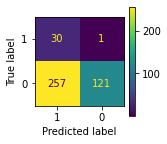

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.105,0.968,0.189,0.369,0.713,0.341,"[0.65, 0.774]"


In [11]:
print("############### Results without encoding ##############")
results1     = train_grid_XGB_model(train_set, valid_set, train_set, valid_set, grid, feat_list)

############### Results encoded data ##############
Best: 0.764444 using {'class_weight': {1: 4}}
AUC    (call)
0.769333 (0.712222) with: {'class_weight': {1: 1}}
0.786333 (0.730000) with: {'class_weight': {1: 2}}
0.780111 (0.737778) with: {'class_weight': {1: 3}}
0.779333 (0.764444) with: {'class_weight': {1: 4}}
0.778222 (0.750000) with: {'class_weight': {1: 5}}
0.755778 (0.718889) with: {'class_weight': {1: 8}}
0.744222 (0.698889) with: {'class_weight': {1: 10}}
0.738111 (0.661111) with: {'class_weight': {1: 25}}
0.736222 (0.661111) with: {'class_weight': {1: 50}}
0.734778 (0.661111) with: {'class_weight': {1: 75}}
0.733556 (0.661111) with: {'class_weight': {1: 99}}
0.733556 (0.661111) with: {'class_weight': {1: 100}}
0.736222 (0.666667) with: {'class_weight': {1: 500}}

time elapased training:  13.586216449737549
Confidence interval for the score: [0.632 - 0.768]


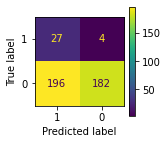

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.121,0.871,0.213,0.511,0.705,0.322,"[0.63, 0.768]"


In [12]:
print("############### Results encoded data ##############")
results1_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, train_set, valid_set, grid, feat_list)

# CURB65 Group 2

In [13]:
X_train_set = X_data_16_18[1]
X_valid_set = X_data_19_20[1]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1037
total admissions 19 20 389
X_train 222
Admissions neg (mortal - class = 0): 111 Admissions pos (recover- class = 1): 111
X_valid 389
Admissions neg (mortal - class = 0): 328 Admissions pos (recover- class = 1): 61

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
144,73017510,22.000,10,66.000,36.000,95.000,60.000,96.000,1.000,1,-1,0,90,0,1,1.000,1
288,76521119,23.000,8,82.000,37.300,103.000,67.000,90.000,1.000,0,-1,0,72,9,0,0.000,1
1008,66176251,18.000,2,66.000,36.300,135.000,62.000,98.000,1.000,0,1,3,88,19,1,0.000,1
1296,25935498,20.000,4,86.000,36.400,92.000,64.000,99.000,1.000,0,-1,0,84,22,0,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
144,-0.085,0.636,-1.313,-1.115,-1.391,-0.864,0.427,1.000,1,-1,0.511,1.071,-0.775,1,1.000
288,0.131,0.529,-0.520,0.260,-1.026,-0.351,-1.085,1.000,0,-1,0.511,-0.507,0.544,0,0.000
1008,-0.947,0.615,-1.313,-0.798,0.436,-0.717,0.930,1.000,0,1,0.250,0.896,2.010,1,0.000
1296,-0.516,0.484,-0.322,-0.692,-1.528,-0.571,1.182,1.000,0,-1,0.511,0.545,2.449,0,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,88572864,16.000,6,73.000,34.900,90.000,44.000,96.000,0.000,1,-1,1,93,6,1,1.000,1
144,62751181,24.000,7,114.000,39.000,137.000,81.000,98.000,1.000,0,1,0,67,0,0,1.000,0
288,21357495,24.000,2,71.000,37.900,150.000,66.000,96.000,0.000,0,-1,0,84,8,1,1.000,0
432,83262936,16.000,1,87.000,36.800,137.000,72.000,95.000,0.000,0,1,0,89,0,0,1.000,0


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-1.377,0.556,-0.966,-2.279,-1.620,-2.037,0.427,0.000,1,-1,0.500,1.334,0.104,1,1.000
144,0.346,0.417,1.066,2.059,0.527,0.676,0.930,1.000,0,1,0.511,-0.945,-0.775,0,1.000
288,0.346,0.615,-1.066,0.895,1.121,-0.424,0.427,0.000,0,-1,0.511,0.545,0.397,1,1.000
432,-1.377,0.333,-0.272,-0.269,0.527,0.016,0.175,0.000,0,1,0.511,0.984,-0.775,0,1.000


,feature,type,parameters
0,rr,Continuous,"[22.394144144144143, 4.642301264341017]"
1,ews,Categorical,0 1 prob 10 4 7 0.636 8 8 9 0...
2,heart_rate,Continuous,"[92.49549549549549, 20.17345546527619]"
3,temperature,Continuous,"[37.05382882882883, 0.9450017249511311]"
4,sbp,Continuous,"[125.45945945945945, 21.891405691398802]"
5,dbp,Continuous,"[71.78603603603604, 13.639523138867764]"
6,Oxygen_Saturation,Continuous,"[94.30630630630631, 3.970006993150189]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############
Best: 0.669949 using {'class_weight': {1: 1}}
AUC    (call)
0.717057 (0.669949) with: {'class_weight': {1: 1}}
0.706003 (0.645455) with: {'class_weight': {1: 2}}
0.692183 (0.633333) with: {'class_weight': {1: 3}}
0.696843 (0.636111) with: {'class_weight': {1: 4}}
0.692505 (0.612374) with: {'class_weight': {1: 5}}
0.687213 (0.590404) with: {'class_weight': {1: 8}}
0.685813 (0.578788) with: {'class_weight': {1: 10}}
0.674839 (0.560354) with: {'class_weight': {1: 25}}
0.670512 (0.554798) with: {'class_weight': {1: 50}}
0.667332 (0.566919) with: {'class_weight': {1: 75}}
0.665416 (0.548990) with: {'class_weight': {1: 99}}
0.665668 (0.545960) with: {'class_weight': {1: 100}}
0.666644 (0.551768) with: {'class_weight': {1: 500}}

time elapased training:  15.913641214370728
Confidence interval for the score: [0.584 - 0.707]


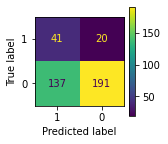

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.230,0.672,0.343,0.596,0.646,0.250,"[0.58, 0.707]"


In [14]:
print("############### Results without encoding ##############")
results2     = train_grid_XGB_model(train_set, valid_set, train_set, valid_set, grid, feat_list)

############### Results encoded data ##############
Best: 0.673232 using {'class_weight': {1: 1}}
AUC    (call)
0.729500 (0.673232) with: {'class_weight': {1: 1}}
0.706061 (0.631313) with: {'class_weight': {1: 2}}
0.700207 (0.624747) with: {'class_weight': {1: 3}}
0.697062 (0.615657) with: {'class_weight': {1: 4}}
0.689050 (0.606818) with: {'class_weight': {1: 5}}
0.684447 (0.588889) with: {'class_weight': {1: 8}}
0.680647 (0.588636) with: {'class_weight': {1: 10}}
0.667080 (0.572727) with: {'class_weight': {1: 25}}
0.669605 (0.554798) with: {'class_weight': {1: 50}}
0.671315 (0.564141) with: {'class_weight': {1: 75}}
0.668480 (0.561364) with: {'class_weight': {1: 99}}
0.668079 (0.561364) with: {'class_weight': {1: 100}}
0.667952 (0.561111) with: {'class_weight': {1: 500}}

time elapased training:  15.736184120178223
Confidence interval for the score: [0.573 - 0.703]


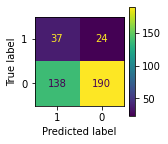

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.211,0.607,0.314,0.584,0.639,0.242,"[0.57, 0.703]"


In [15]:
print("############### Results encoded data ##############")
results2_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, train_set, valid_set, grid, feat_list)

# CURB65 Group 3

In [16]:
X_train_set = X_data_16_18[2]
X_valid_set = X_data_19_20[2]
train_set, valid_set = train_valid_sets(X_train_set, X_valid_set)
print("")
train_set_norm, valid_set_norm, _ = encoding_data(train_set, valid_set, feat_list, data_types)

total admissions 16 18 1095
total admissions 19 20 259
X_train 394
Admissions neg (mortal - class = 0): 197 Admissions pos (recover- class = 1): 197
X_valid 259
Admissions neg (mortal - class = 0): 206 Admissions pos (recover- class = 1): 53

----------------------------------TRAIN SET---------------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,79958796,22.000,8,91.000,36.300,140.000,57.000,90.000,1.000,0,-1,0,79,8,0,0.000,1
144,54340823,38.000,7,95.000,36.100,136.000,88.000,94.000,1.000,0,-1,0,91,0,1,1.000,1
1440,58516806,23.000,8,109.000,37.300,89.000,51.000,97.000,1.000,0,1,3,87,6,0,0.000,1
2016,68938901,28.000,8,62.000,35.700,172.000,70.000,94.000,1.000,1,1,0,100,4,1,1.000,1


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.314,0.583,-0.096,-0.921,0.896,-0.680,-0.928,1.000,0,-1,0.495,-0.542,0.474,0,0.000
144,2.345,0.488,0.093,-1.160,0.716,1.261,-0.063,1.000,0,-1,0.495,1.001,-1.096,1,1.000
1440,-0.148,0.583,0.755,0.271,-1.403,-1.056,0.586,1.000,0,1,0.528,0.486,0.082,0,0.000
2016,0.683,0.583,-1.468,-1.637,2.339,0.134,-0.063,1.000,1,1,0.495,2.158,-0.311,1,1.000


----------------------------------VALIDATION SET----------------------------------------------------------


,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,59603192,26.000,6,77.000,38.100,145.000,55.000,96.000,1.000,0,-1,0,84,12,0,1.000,0
144,33386907,18.000,1,87.000,36.700,129.000,75.000,95.000,0.000,0,1,0,88,3,1,0.000,0
288,80377128,22.000,6,87.000,36.200,100.000,71.000,96.000,1.000,0,1,0,84,4,1,1.000,1
432,26956465,24.000,3,91.000,36.800,116.000,49.000,100.000,0.000,0,1,11,94,0,0,0.000,0


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,0.351,0.585,-0.759,1.225,1.121,-0.806,0.370,1.000,0,-1,0.495,0.101,1.259,0,1.000
144,-0.979,0.476,-0.286,-0.444,0.400,0.447,0.153,0.000,0,1,0.495,0.615,-0.507,1,0.000
288,-0.314,0.585,-0.286,-1.041,-0.907,0.197,0.370,1.000,0,1,0.495,0.101,-0.311,1,1.000
432,0.018,0.478,-0.096,-0.325,-0.186,-1.181,1.235,0.000,0,1,0.000,1.386,-1.096,0,0.000


,feature,type,parameters
0,rr,Continuous,"[23.890862944162436, 6.016793103758225]"
1,ews,Categorical,0 1 prob 8 10 14 0.583 7 22 21 0...
2,heart_rate,Continuous,"[93.03934010152284, 21.142804178258118]"
3,temperature,Continuous,"[37.07258883248731, 0.8384888251493963]"
4,sbp,Continuous,"[120.1256345177665, 22.18070196528276]"
5,dbp,Continuous,"[67.86167512690355, 15.965389673159168]"
6,Oxygen_Saturation,Continuous,"[94.29060913705584, 4.622237226895378]"
7,Assisted_O2,Binary,
8,Confusion,Binary,
9,sex,Binary,


############### Results without encoding ##############
Best: 0.585526 using {'class_weight': {1: 1}}
AUC    (call)
0.628127 (0.585526) with: {'class_weight': {1: 1}}
0.615759 (0.516228) with: {'class_weight': {1: 2}}
0.599596 (0.492544) with: {'class_weight': {1: 3}}
0.595816 (0.470965) with: {'class_weight': {1: 4}}
0.593934 (0.467632) with: {'class_weight': {1: 5}}
0.588243 (0.464035) with: {'class_weight': {1: 8}}
0.588737 (0.451930) with: {'class_weight': {1: 10}}
0.582461 (0.436754) with: {'class_weight': {1: 25}}
0.581680 (0.435000) with: {'class_weight': {1: 50}}
0.581868 (0.431842) with: {'class_weight': {1: 75}}
0.584386 (0.426930) with: {'class_weight': {1: 99}}
0.584686 (0.425263) with: {'class_weight': {1: 100}}
0.580868 (0.432105) with: {'class_weight': {1: 500}}

time elapased training:  19.204678058624268
Confidence interval for the score: [0.548 - 0.683]


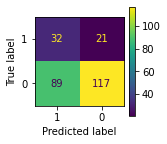

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.264,0.604,0.368,0.575,0.615,0.240,"[0.55, 0.683]"


In [17]:
print("############### Results without encoding ##############")
results3     = train_grid_XGB_model(train_set, valid_set, train_set, valid_set, grid, feat_list)

############### Results encoded data ##############
Best: 0.594649 using {'class_weight': {1: 1}}
AUC    (call)
0.637445 (0.594649) with: {'class_weight': {1: 1}}
0.622831 (0.546579) with: {'class_weight': {1: 2}}
0.613099 (0.506754) with: {'class_weight': {1: 3}}
0.607048 (0.498070) with: {'class_weight': {1: 4}}
0.602667 (0.477544) with: {'class_weight': {1: 5}}
0.595261 (0.476140) with: {'class_weight': {1: 8}}
0.599263 (0.462193) with: {'class_weight': {1: 10}}
0.598307 (0.443684) with: {'class_weight': {1: 25}}
0.594664 (0.443772) with: {'class_weight': {1: 50}}
0.599706 (0.445175) with: {'class_weight': {1: 75}}
0.595818 (0.443509) with: {'class_weight': {1: 99}}
0.594912 (0.443509) with: {'class_weight': {1: 100}}
0.595662 (0.443509) with: {'class_weight': {1: 500}}

time elapased training:  18.947284936904907
Confidence interval for the score: [0.546 - 0.677]


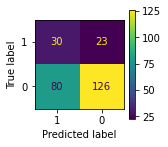

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.273,0.566,0.368,0.602,0.610,0.240,"[0.55, 0.677]"


In [18]:
print("############### Results encoded data ##############")
results3_enc = train_grid_XGB_model(train_set_norm, valid_set_norm, train_set, valid_set, grid, feat_list)

# Results

# AUROC curve

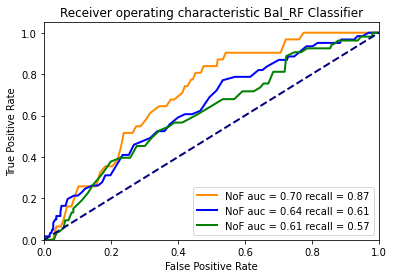

In [19]:
title = 'Bal_RF Classifier'
plt.figure()
colors = ['darkorange', 'b','g','r','c', 'm']
i = 0

results_encs =[results1_enc, results2_enc, results3_enc]

for results_enc in results_encs:

    df_results_valid = results_enc[1]
    dict_fpr_tpr     = results_enc[2]

    key = 'NoF'
    val = dict_fpr_tpr[key]
    auc = df_results_valid.loc[key,'AUC']
    rcl = df_results_valid.loc[key,'Recall']
    fpr, tpr = val

    lw = 2

    plt.plot(fpr,  tpr,  color= colors[i],  lw=lw,label= key + " auc = {:,.2f} recall = {:,.2f}".format(auc, rcl) 
        #label="ROC curve (area = %0.2f)" % metrics.roc_auc[2],
    )
    i = i + 1
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic "+ title)
plt.legend(loc="lower right")
#plt.savefig('AUROC_'+title+'.png', transparent = True, bbox_inches = "tight")
plt.show()

In [20]:
for r in results_encs:
    display(r[1])

,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.121,0.871,0.213,0.511,0.705,0.322,"[0.63, 0.768]"


,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.211,0.607,0.314,0.584,0.639,0.242,"[0.57, 0.703]"


,Precision,Recall,F1_Score,Accuracy,AUC,brier,AUC_IC
NoF,0.273,0.566,0.368,0.602,0.610,0.240,"[0.55, 0.677]"


In [21]:
pickle.dump([results_encs], open('dict_fpr_trp_'+title+'.pickle', 'wb'))